In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science","bright","grid"])

from nanonets import Simulation
from nanonets.utils import BLUE_COLOR, RED_COLOR

# Parameter
N_NP    = 9
idx_g   = [12,3,4]
idx_b   = [15,30,20]
topo    = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
            [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],[N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]], "electrode_type": ['constant']*8}

# Voltage
U0      = 0.02
volt    = np.zeros(len(topo["e_pos"])+1)
volt[0] = U0
volt    = volt[np.newaxis]

# Disorder
N_J_TOTAL   = 2*N_NP*(N_NP-1)
MEAN_R2_MAX = 1e9

In [ ]:
def run_simulation(MEAN_R2=25, cut=None, seed=0):
    
    # Setup Network
    sim_c = Simulation(topo)
    if MEAN_R2 == 25:
        sim_c = Simulation(topo)
    else:
        res_info2 = {'N':N_J_TOTAL//3,'mean_R':MEAN_R2,'std_R':0.0}
        sim_c = Simulation(topo, res_info2=res_info2, seed=seed)
    if cut is not None:
        sim_c.update_junction_resistances(junctions=[cut],R=MEAN_R2_MAX)

    # Run
    sim_c.run_static_voltages(volt, 7)

    y = sim_c.get_observable_storage()
    I = sim_c.get_network_current_storage()

    return y, I

In [ ]:
R_vals = [25,50,100,200,400,800,1600]
y_olds = {}
y_news = {}
I_olds = {}
I_news = {}
F_vals = {}

for seed in idx_g+idx_b:

    y_olds[seed] = []
    y_news[seed] = []
    I_olds[seed] = []
    I_news[seed] = []
    F_vals[seed] = []

    for R2 in R_vals:

        # First Run
        y_old, I_old = run_simulation(MEAN_R2=R2, cut=None, seed=seed)

        # Find most dominant junction
        keys = []
        vals = []
        for key, val in I_old.items():
            keys.append(key)
            vals.append(val[0])
        juncs = np.array(keys)[np.argsort(-np.array(vals))]-len(topo["e_pos"])
        for junc in juncs:
            if junc[0] >= 0 and junc[1] >= 0:
                junc_to_deleat = junc
                break

        # Second Run
        y_new, I_new = run_simulation(MEAN_R2=R2, cut=junc_to_deleat, seed=seed)
        

        # Append results
        y_olds[seed].append(y_old[0])
        y_news[seed].append(y_new[0])
        F_vals[seed].append(1 - y_new[0]/y_old[0])
        I_olds[seed].append(I_old)
        I_news[seed].append(I_new)

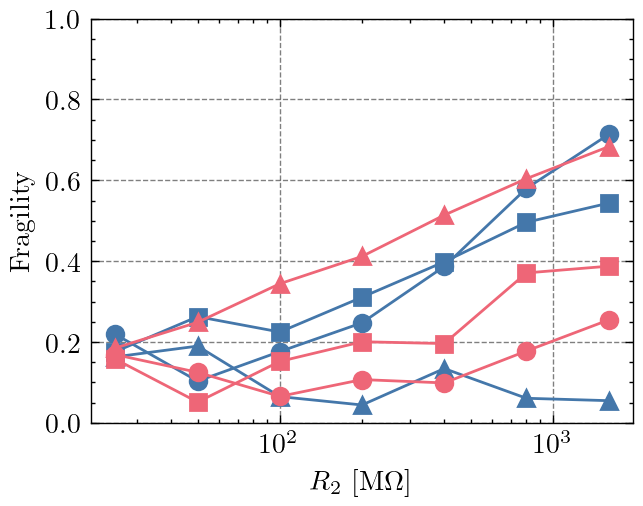

In [130]:
ms  = ['o','s','^']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for n, i in enumerate(idx_g):
    ax.plot(R_vals, F_vals[i], color=BLUE_COLOR, marker=ms[n])
for n, i in enumerate(idx_b):
    ax.plot(R_vals, F_vals[i], c=RED_COLOR, marker=ms[n])
_   = ax.set_xscale('log')
_   = ax.set_xlabel("$R_2~[\mathrm{M\Omega}]$")
_   = ax.set_ylabel("Fragility")
_   = ax.set_ylim(0,1)

In [135]:
junc+8

array([12, 21])

In [136]:
I_old[(12,21)]

array([43850214.92418554])

In [137]:
I_old

{(np.int64(0), np.int64(12)): array([53740604.82337007]),
 (np.int64(1), np.int64(8)): array([16.08410439]),
 (np.int64(2), np.int64(16)): array([3.75266598e-12]),
 (np.int64(3), np.int64(44)): array([4.57670135e-08]),
 (np.int64(4), np.int64(52)): array([1878.30272099]),
 (np.int64(5), np.int64(80)): array([57707.29086629]),
 (np.int64(6), np.int64(88)): array([292453.89645221]),
 (np.int64(7), np.int64(84)): array([51814.45100114]),
 (np.int64(8), np.int64(1)): array([23019845.42033299]),
 (np.int64(8), np.int64(9)): array([13569.84628053]),
 (np.int64(8), np.int64(17)): array([2002.39435333]),
 (np.int64(9), np.int64(8)): array([14247139.70666523]),
 (np.int64(9), np.int64(10)): array([2.76642532e-17]),
 (np.int64(9), np.int64(18)): array([21744.06648781]),
 (np.int64(10), np.int64(9)): array([1236147.39722408]),
 (np.int64(10), np.int64(11)): array([1.12931373e-21]),
 (np.int64(10), np.int64(19)): array([3249034.59040701]),
 (np.int64(11), np.int64(10)): array([4411999.75116089]),


In [132]:
I_new

{(np.int64(0), np.int64(12)): array([17420601.85078158]),
 (np.int64(1), np.int64(8)): array([9630.52900199]),
 (np.int64(2), np.int64(16)): array([50.51720189]),
 (np.int64(3), np.int64(44)): array([8696.01984588]),
 (np.int64(4), np.int64(52)): array([3278.33564851]),
 (np.int64(5), np.int64(80)): array([1854.18053577]),
 (np.int64(6), np.int64(88)): array([9733.74686261]),
 (np.int64(7), np.int64(84)): array([54562.34755751]),
 (np.int64(8), np.int64(1)): array([3680444.37381222]),
 (np.int64(8), np.int64(9)): array([1.67200606e-06]),
 (np.int64(8), np.int64(17)): array([98.72276808]),
 (np.int64(9), np.int64(8)): array([2512384.40929141]),
 (np.int64(9), np.int64(10)): array([6.09777766e-13]),
 (np.int64(9), np.int64(18)): array([7734.79003436]),
 (np.int64(10), np.int64(9)): array([285087.9283181]),
 (np.int64(10), np.int64(11)): array([10971.80717813]),
 (np.int64(10), np.int64(19)): array([2851619.77170166]),
 (np.int64(11), np.int64(10)): array([3166757.88920065]),
 (np.int64(1

In [138]:
I_new[(12,21)]

array([11.36554475])